In [1]:
# Import libraries
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Set display options
pl.Config.set_tbl_rows(20)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading & Overview

In [2]:
# Load data using recommender functions (auto-loads all chunks)
import sys
sys.path.append('..')

from src.recommender import load_transactions, load_items, load_users

print("Loading data from chunks...")
print("NOTE: For EDA, we'll sample 10% of data (~3.6M rows) to avoid memory issues")
print("This is sufficient for pattern analysis!\n")

# Load all data (LazyFrame - not yet executed)
transactions_lazy = load_transactions()
items_lazy = load_items()
users_lazy = load_users()

# SAMPLE 10% for EDA using hash-based filtering (efficient, no full collect!)
print("Sampling 10% of transactions using hash filter...")
transactions = transactions_lazy.filter(
    (pl.col("customer_id").hash(seed=42) % 10) == 0
).collect()

items = items_lazy.collect()  # Small dataset, load all
users = users_lazy.collect()  # Small dataset, load all

print("\nData loaded successfully!")
print(f"Transactions: {transactions.shape} (~10% sample)")
print(f"Items: {items.shape}")
print(f"Users: {users.shape}")

Loading data from chunks...
NOTE: For EDA, we'll sample 10% of data (~3.6M rows) to avoid memory issues
This is sufficient for pattern analysis!

Sampling 10% of transactions using hash filter...

Data loaded successfully!
Transactions: (3583618, 16) (~10% sample)
Items: (27332, 34)
Users: (4573964, 18)


In [3]:
# Quick schema overview
print("\n=== TRANSACTIONS SCHEMA ===")
print(transactions.schema)
print("\nSample:")
transactions.head()


=== TRANSACTIONS SCHEMA ===
Schema([('timestamp', Int64), ('user_id', String), ('item_id', String), ('event_type', String), ('event_value', Decimal(precision=38, scale=4)), ('price', Decimal(precision=38, scale=4)), ('date_key', Int32), ('quantity', Int32), ('customer_id', Int32), ('created_date', Datetime(time_unit='us', time_zone=None)), ('updated_date', Datetime(time_unit='us', time_zone=None)), ('channel', String), ('payment', String), ('location', Int32), ('discount', Decimal(precision=38, scale=4)), ('is_deleted', Boolean)])

Sample:


timestamp,user_id,item_id,event_type,event_value,price,date_key,quantity,customer_id,created_date,updated_date,channel,payment,location,discount,is_deleted
i64,str,str,str,"decimal[38,4]","decimal[38,4]",i32,i32,i32,datetime[μs],datetime[μs],str,str,i32,"decimal[38,4]",bool
1735063528,"""bd17a87916763e0d4da9a9fb8e71cd…","""6796000000002""","""Purchase""",1.0000,299000.0000,20241224,1,8130289,2024-12-24 18:05:28.733,2024-12-24 18:05:28.733,"""In-Store""","""Tiền mặt""",599,0.0000,false
1735073830,"""0c725ed78f26cf57d8d4e3f1780dfe…","""5420000000002""","""Purchase""",1.0000,26000.0000,20241224,1,5730292,2024-12-24 20:57:10.713,2024-12-24 20:57:10.713,"""In-Store""","""Tiền mặt""",409,0.0000,false
1735225607,"""c66d941166d2161133c39ed964ff11…","""4869000000004""","""Purchase""",1.0000,15000.0000,20241226,1,2307668,2024-12-26 15:06:47.097,2024-12-26 15:06:47.097,"""In-Store""","""Tiền mặt""",378,0.0000,false
1735064426,"""abf4f479f319e7de316366852cb639…","""6665000000004""","""Purchase""",2.0000,24360.6174,20241224,2,7430999,2024-12-24 18:20:26.680,2024-12-24 18:20:26.730,"""In-Store""","""Tiền mặt""",563,15278.7652,false
1735062640,"""128d7aae94e04cd452a2f0d48dedb0…","""6072000000006""","""Purchase""",1.0000,16000.0000,20241224,1,4342756,2024-12-24 17:50:40.727,2024-12-24 17:50:40.727,"""In-Store""","""VNPay""",573,0.0000,false


In [4]:
print("\n=== ITEMS SCHEMA ===")
print(items.schema)
print("\nSample:")
items.head()


=== ITEMS SCHEMA ===
Schema([('p_id', Int32), ('item_id', String), ('price', Decimal(precision=38, scale=4)), ('category_l1_id', Int32), ('category_l1', String), ('category_l2_id', Int32), ('category_l2', String), ('category_l3_id', Int32), ('category_l3', String), ('category_id', Int32), ('category', String), ('description', String), ('brand', String), ('manufacturer', String), ('creation_timestamp', Int64), ('is_deleted', Boolean), ('created_date', Datetime(time_unit='us', time_zone=None)), ('updated_date', Datetime(time_unit='us', time_zone=None)), ('sync_status_id', Int32), ('last_sync_date', Datetime(time_unit='us', time_zone=None)), ('sync_error_message', String), ('image_url', String), ('gender_target', String), ('age_group', String), ('item_type', String), ('gp', Decimal(precision=38, scale=4)), ('weight', Float32), ('color', String), ('size', String), ('origin', String), ('volume', String), ('material', String), ('sale_status', Int32), ('description_new', String)])

Sample:


p_id,item_id,price,category_l1_id,category_l1,category_l2_id,category_l2,category_l3_id,category_l3,category_id,category,description,brand,manufacturer,creation_timestamp,is_deleted,created_date,updated_date,sync_status_id,last_sync_date,sync_error_message,image_url,gender_target,age_group,item_type,gp,weight,color,size,origin,volume,material,sale_status,description_new
i32,str,"decimal[38,4]",i32,str,i32,str,i32,str,i32,str,str,str,str,i64,bool,datetime[μs],datetime[μs],i32,datetime[μs],str,str,str,str,str,"decimal[38,4]",f32,str,str,str,str,str,i32,str
17065,"""0502020000004""",99000.0000,1,"""Babycare""",35,"""Bình sữa, phụ kiện""",7050,"""Núm ty""",7058,"""Núm ty Dr Brown""","""Không xác định""","""Dr.Brown's""","""Không xác định""",1333531544,false,2012-04-04 09:25:44.240,2025-08-18 09:59:19.847,2,2025-07-18 17:59:29.898256,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",36828.0000,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",0,"""Chi tiết sản phẩm …"
72370,"""0010290040150""",69000.0000,3292,"""Thời trang""",3958,"""Cơ cấu hàng cũ""",7007,"""Thời trang bé trai, bé gái cũ""",6987,"""Bộ quần áo bé gái""","""Không xác định""","""Con Cưng""","""Không xác định""",1503046250,false,2017-08-18 08:50:50.713,2025-09-18 16:05:42.360,null,null,null,"""Không xác định""","""Bé Gái""","""Từ 3Y""","""Bộ quần áo""",0.0000,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",0,"""Không xác định"""
31154,"""0008010000015""",45000.0000,351,"""Đồ chơi & Sách""",2033,"""0-1Y""",2118,"""Gặm nướu""",2121,"""Gặm nướu khác""","""- Chất liệu: Sản phẩm được làm…","""Thương hiệu khác""","""Không xác định""",1358501584,false,2013-01-18 09:33:04.260,2025-09-27 00:05:36.233,2,2025-07-18 17:59:29.898256,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",14490.0000,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",0,"""Chi tiết sản phẩm …"
46123,"""0020010000094""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2276,"""Merries_Sơ Sinh""","""﻿﻿Tã dán Merries size S 82 miế…","""Merries Nhật""","""Không xác định""",1400062039,false,2014-05-14 10:07:19.603,2025-09-27 00:05:36.233,2,2025-07-18 17:59:29.898256,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",59749.0000,null,"""Không xác định""","""Không xác định""","""Nhật Bản, Nhật Bản""","""Không xác định""","""Giấy, bột giấy, vải không dệt,…",0,"""Không xác định"""
46127,"""0020010000098""",401000.0000,2222,"""Tã""",2272,"""Merries""",2275,"""Merries""",2278,"""Merries_Tã Quần""","""﻿﻿﻿Bỉm tã quần Merries size M …","""Merries Nhật""","""Không xác định""",1400062040,false,2014-05-14 10:07:20.370,2025-09-27 00:05:36.233,2,2025-07-18 17:59:29.898256,null,"""Không xác định""","""Không xác định""","""Không xác định""","""Không xác định""",65764.0000,null,"""Không xác định""","""Không xác định""","""Nhật Bản, Nhật Bản""","""Không xác định""","""Giấy, bột giấy, vải không dệt,…",0,"""Không xác định"""


In [5]:
print("\n=== USERS SCHEMA ===")
print(users.schema)
print("\nSample:")
users.head()


=== USERS SCHEMA ===
Schema([('customer_id', Int32), ('gender', String), ('location', Int32), ('province', String), ('membership', String), ('timestamp', Int64), ('created_date', Datetime(time_unit='us', time_zone=None)), ('updated_date', Datetime(time_unit='us', time_zone=None)), ('sync_status_id', Int32), ('last_sync_date', Datetime(time_unit='us', time_zone=None)), ('sync_error_message', String), ('region', String), ('location_name', String), ('install_app', String), ('install_date', Int64), ('district', String), ('user_id', String), ('is_deleted', Boolean)])

Sample:


customer_id,gender,location,province,membership,timestamp,created_date,updated_date,sync_status_id,last_sync_date,sync_error_message,region,location_name,install_app,install_date,district,user_id,is_deleted
i32,str,i32,str,str,i64,datetime[μs],datetime[μs],i32,datetime[μs],str,str,str,str,i64,str,str,bool
14732,"""Nam""",155,"""Hồ Chí Minh""","""Standard""",1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đông Nam Bộ""","""HCM - Grand View Phú Mỹ Hưng""","""In-Store""",1306281600,"""7""","""e1e48206652bf8c279ff0206c69a80…",false
15126,"""Nữ""",300,"""Hồ Chí Minh""","""Standard""",1306357911,2011-05-25 21:11:51.677,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đông Nam Bộ""","""HCM - 121A Nguyễn Duy Trinh""","""In-Store""",1306281600,"""Thủ Đức""","""77891759204bd27e69fb11a7b92889…",false
29718,"""Nữ""",157,"""Bến Tre""","""Standard""",1312126692,2011-07-31 15:38:12.750,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đồng bằng sông Cửu Long""","""BTR - 179 Nguyễn Đình Chiểu""","""In-Store""",1582070400,"""Bến Tre""","""b8041b584a0bb6655361727a0a6108…",false
30077,"""Nữ""",53,"""Hồ Chí Minh""","""Standard""",1314302782,2011-08-25 20:06:22.797,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đông Nam Bộ""","""HCM - 101 Trần Quang Khải""","""In-Store""",1314230400,"""1""","""c52ceaca44a83ec41a219cfaff0e05…",false
30085,"""Nữ""",660,"""Hồ Chí Minh""","""Standard""",1314310024,2011-08-25 22:07:04.267,2025-07-07 15:33:10.201316,2,2025-07-16 11:54:29.816986,null,"""Đông Nam Bộ""","""HCM - 85-87 Tây Thạnh""","""In-Store""",1314230400,"""Tân Phú""","""74ac5764f5d67d341aacf238d7762f…",false


## 2. Task 1: Univariate Analysis

### 2.1 Basic Statistics & Null Rates

In [6]:
def compute_null_rates(df: pl.DataFrame, name: str) -> pl.DataFrame:
    """Compute null rates for all columns."""
    total = df.shape[0]
    
    null_counts = df.select([
        pl.col(col).is_null().sum().alias(col) 
        for col in df.columns
    ])
    
    null_rates = pl.DataFrame({
        'column': df.columns,
        'null_count': null_counts.row(0),
        'null_rate': [n / total for n in null_counts.row(0)],
    }).sort('null_rate', descending=True)
    
    print(f"\n{'='*50}")
    print(f"NULL RATES - {name}")
    print(f"{'='*50}")
    print(null_rates)
    
    return null_rates

# Compute null rates for all datasets
null_txns = compute_null_rates(transactions, 'TRANSACTIONS')
null_items = compute_null_rates(items, 'ITEMS')
null_users = compute_null_rates(users, 'USERS')


NULL RATES - TRANSACTIONS
shape: (16, 3)
┌──────────────┬────────────┬───────────┐
│ column       ┆ null_count ┆ null_rate │
│ ---          ┆ ---        ┆ ---       │
│ str          ┆ i64        ┆ f64       │
╞══════════════╪════════════╪═══════════╡
│ timestamp    ┆ 0          ┆ 0.0       │
│ user_id      ┆ 0          ┆ 0.0       │
│ item_id      ┆ 0          ┆ 0.0       │
│ event_type   ┆ 0          ┆ 0.0       │
│ event_value  ┆ 0          ┆ 0.0       │
│ price        ┆ 0          ┆ 0.0       │
│ date_key     ┆ 0          ┆ 0.0       │
│ quantity     ┆ 0          ┆ 0.0       │
│ customer_id  ┆ 0          ┆ 0.0       │
│ created_date ┆ 0          ┆ 0.0       │
│ updated_date ┆ 0          ┆ 0.0       │
│ channel      ┆ 0          ┆ 0.0       │
│ payment      ┆ 0          ┆ 0.0       │
│ location     ┆ 0          ┆ 0.0       │
│ discount     ┆ 0          ┆ 0.0       │
│ is_deleted   ┆ 0          ┆ 0.0       │
└──────────────┴────────────┴───────────┘

NULL RATES - ITEMS
shape: (34, 3)

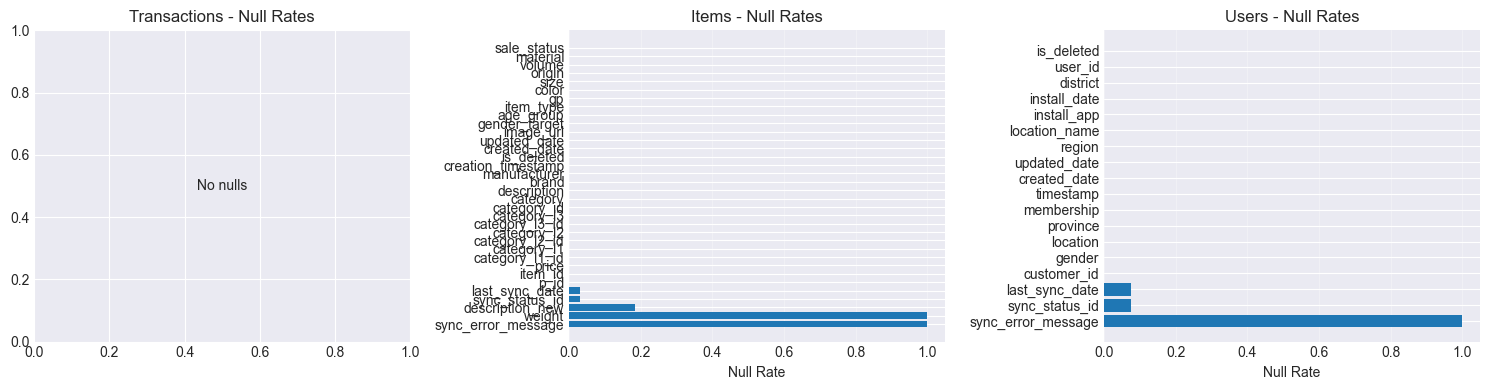

In [7]:
# Visualize null rates
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (df_null, title) in zip(axes, [
    (null_txns, 'Transactions'),
    (null_items, 'Items'),
    (null_users, 'Users')
]):
    if df_null.shape[0] > 0 and df_null['null_rate'].max() > 0:
        ax.barh(df_null['column'].to_list(), df_null['null_rate'].to_list())
        ax.set_xlabel('Null Rate')
        ax.set_title(f'{title} - Null Rates')
        ax.grid(axis='x', alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No nulls', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{title} - Null Rates')

plt.tight_layout()
plt.show()

### 2.2 Customer Statistics

In [8]:
# Customer-level statistics
customer_stats = transactions.group_by('customer_id').agg([
    pl.count('item_id').alias('num_purchases'),
    pl.n_unique('item_id').alias('num_unique_items'),
    (pl.col('created_date').max() - pl.col('created_date').min()).dt.total_days().alias('days_active'),
])

print("\nCustomer Statistics:")
print(customer_stats.describe())


Customer Statistics:
shape: (9, 5)
┌────────────┬─────────────┬───────────────┬──────────────────┬─────────────┐
│ statistic  ┆ customer_id ┆ num_purchases ┆ num_unique_items ┆ days_active │
│ ---        ┆ ---         ┆ ---           ┆ ---              ┆ ---         │
│ str        ┆ f64         ┆ f64           ┆ f64              ┆ f64         │
╞════════════╪═════════════╪═══════════════╪══════════════════╪═════════════╡
│ count      ┆ 244332.0    ┆ 244332.0      ┆ 244332.0         ┆ 244332.0    │
│ null_count ┆ 0.0         ┆ 0.0           ┆ 0.0              ┆ 0.0         │
│ mean       ┆ 5.6387e6    ┆ 14.667002     ┆ 10.125452        ┆ 98.856953   │
│ std        ┆ 2.3428e6    ┆ 30.469183     ┆ 17.788358        ┆ 125.710531  │
│ min        ┆ 15126.0     ┆ 1.0           ┆ 1.0              ┆ 0.0         │
│ 25%        ┆ 3.899407e6  ┆ 1.0           ┆ 1.0              ┆ 0.0         │
│ 50%        ┆ 6.643079e6  ┆ 4.0           ┆ 3.0              ┆ 14.0        │
│ 75%        ┆ 7.55889e6   ┆

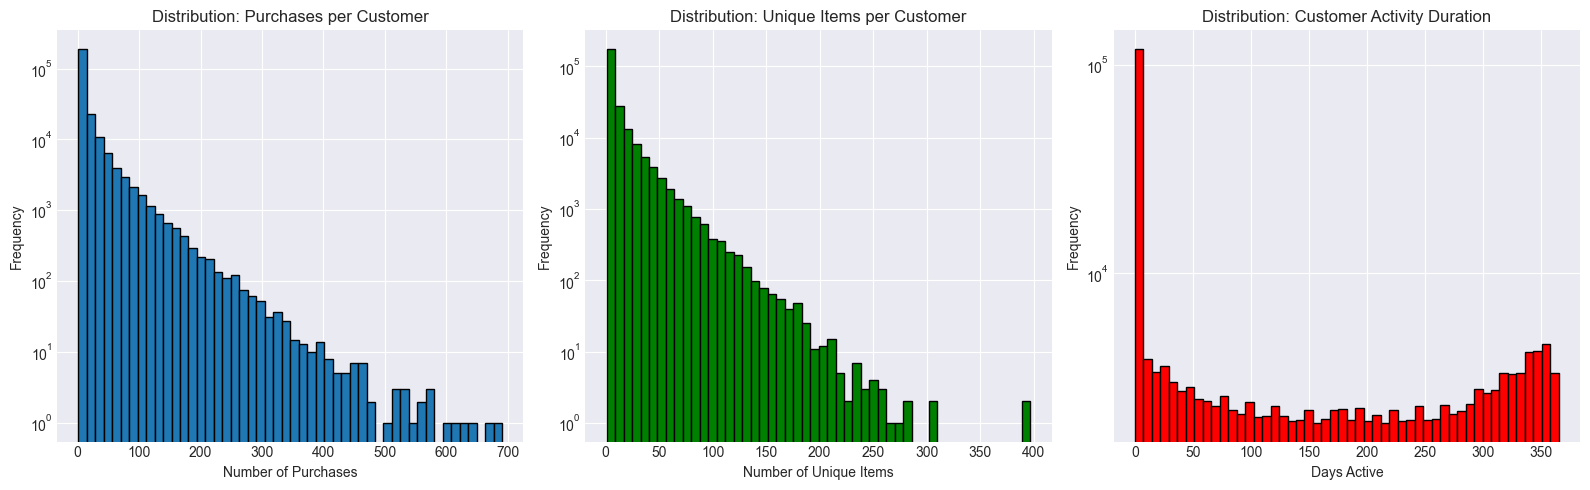

In [9]:
# Plot customer distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Number of purchases per customer
axes[0].hist(customer_stats['num_purchases'].to_numpy(), bins=50, edgecolor='black')
axes[0].set_xlabel('Number of Purchases')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution: Purchases per Customer')
axes[0].set_yscale('log')

# Unique items per customer
axes[1].hist(customer_stats['num_unique_items'].to_numpy(), bins=50, edgecolor='black', color='green')
axes[1].set_xlabel('Number of Unique Items')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution: Unique Items per Customer')
axes[1].set_yscale('log')

# Days active
axes[2].hist(customer_stats['days_active'].to_numpy(), bins=50, edgecolor='black', color='red')
axes[2].set_xlabel('Days Active')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution: Customer Activity Duration')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

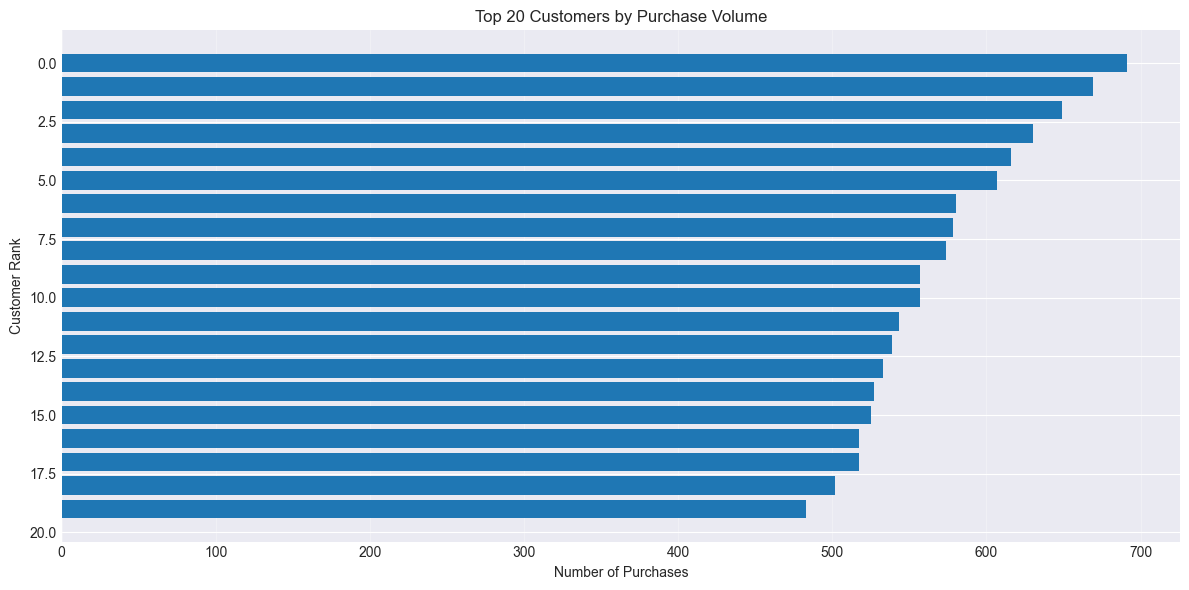

In [10]:
# Top customers by purchase volume
top_customers = customer_stats.sort('num_purchases', descending=True).head(20)

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_customers)), top_customers['num_purchases'].to_list())
plt.xlabel('Number of Purchases')
plt.ylabel('Customer Rank')
plt.title('Top 20 Customers by Purchase Volume')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 2.3 Item Statistics

In [11]:
# Item popularity
item_stats = transactions.group_by('item_id').agg([
    pl.count().alias('num_purchases'),
    pl.n_unique('customer_id').alias('num_customers'),
]).join(items, on='item_id', how='left')

print("\nItem Statistics:")
print(item_stats.select(['num_purchases', 'num_customers']).describe())


Item Statistics:
shape: (9, 3)
┌────────────┬───────────────┬───────────────┐
│ statistic  ┆ num_purchases ┆ num_customers │
│ ---        ┆ ---           ┆ ---           │
│ str        ┆ f64           ┆ f64           │
╞════════════╪═══════════════╪═══════════════╡
│ count      ┆ 15573.0       ┆ 15573.0       │
│ null_count ┆ 0.0           ┆ 0.0           │
│ mean       ┆ 230.117383    ┆ 158.862904    │
│ std        ┆ 992.395681    ┆ 593.30791     │
│ min        ┆ 1.0           ┆ 1.0           │
│ 25%        ┆ 4.0           ┆ 3.0           │
│ 50%        ┆ 16.0          ┆ 16.0          │
│ 75%        ┆ 62.0          ┆ 59.0          │
│ max        ┆ 30308.0       ┆ 19046.0       │
└────────────┴───────────────┴───────────────┘


C:\Users\ASUS\AppData\Local\Temp\ipykernel_16420\4090016549.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('num_purchases'),


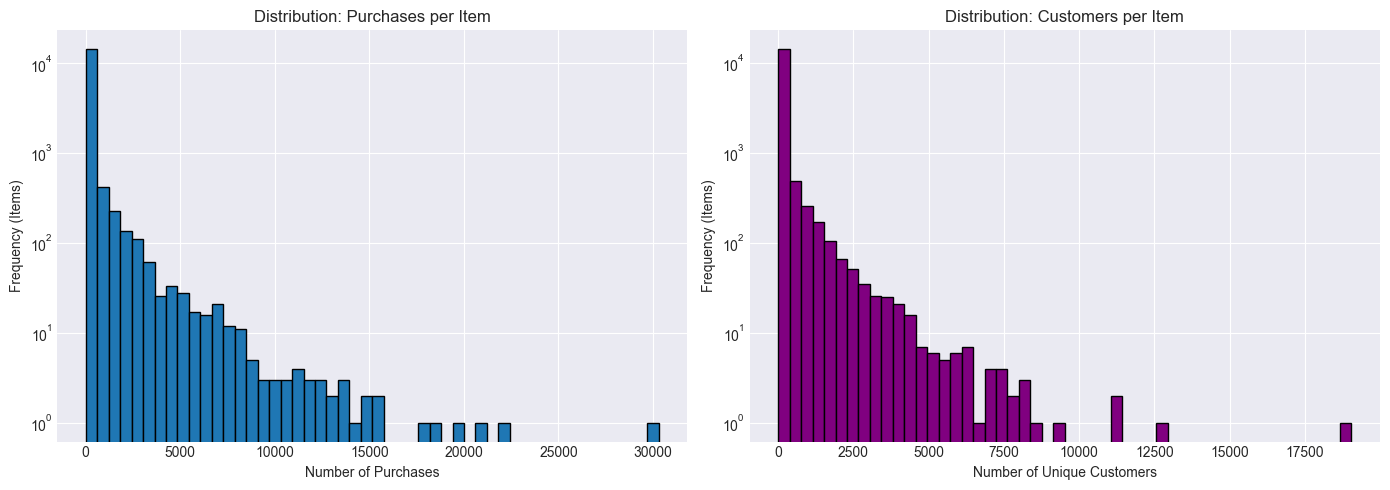

In [12]:
# Plot item distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Purchases per item
axes[0].hist(item_stats['num_purchases'].to_numpy(), bins=50, edgecolor='black')
axes[0].set_xlabel('Number of Purchases')
axes[0].set_ylabel('Frequency (Items)')
axes[0].set_title('Distribution: Purchases per Item')
axes[0].set_yscale('log')

# Customers per item
axes[1].hist(item_stats['num_customers'].to_numpy(), bins=50, edgecolor='black', color='purple')
axes[1].set_xlabel('Number of Unique Customers')
axes[1].set_ylabel('Frequency (Items)')
axes[1].set_title('Distribution: Customers per Item')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

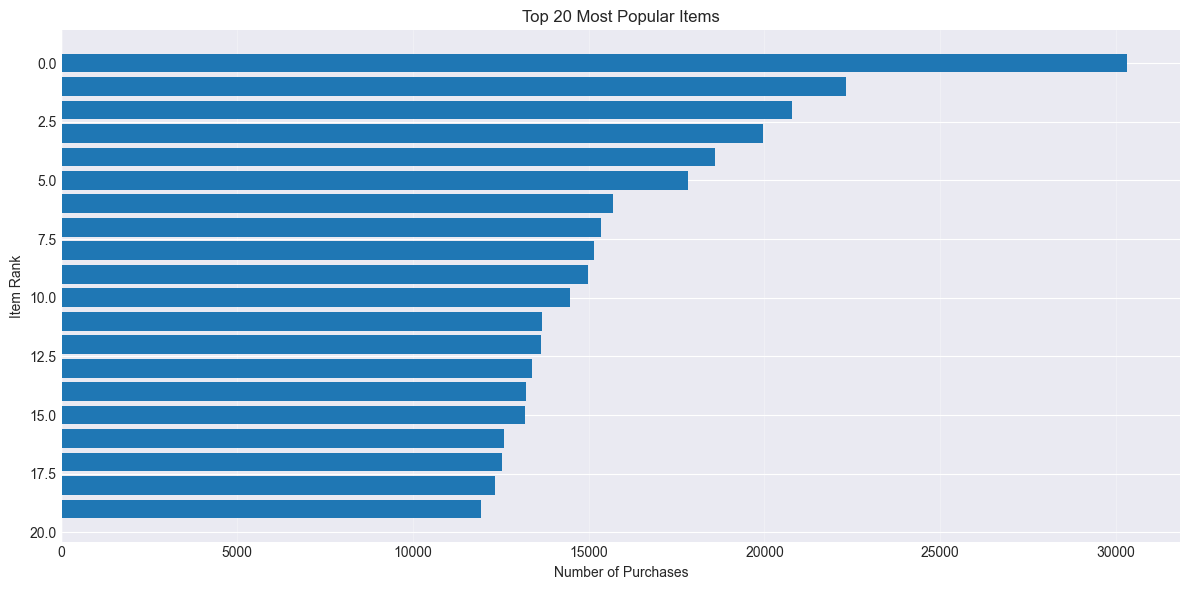

In [13]:
# Top items by popularity
top_items = item_stats.sort('num_purchases', descending=True).head(20)

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_items)), top_items['num_purchases'].to_list())
plt.xlabel('Number of Purchases')
plt.ylabel('Item Rank')
plt.title('Top 20 Most Popular Items')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 2.4 Categorical Feature Distributions


Top 10 Brands:
shape: (10, 2)
┌──────────────────────┬───────┐
│ brand                ┆ count │
│ ---                  ┆ ---   │
│ str                  ┆ u32   │
╞══════════════════════╪═══════╡
│ Animo                ┆ 8149  │
│ Không xác định       ┆ 5480  │
│ CF (ConCung Fashion) ┆ 5426  │
│ Thương hiệu khác     ┆ 607   │
│ Con Cưng             ┆ 484   │
│ TOYCITY              ┆ 300   │
│ ConCung Good         ┆ 211   │
│ Nous                 ┆ 140   │
│ Pigeon               ┆ 120   │
│ Mesuca               ┆ 114   │
└──────────────────────┴───────┘


C:\Users\ASUS\AppData\Local\Temp\ipykernel_16420\1026688296.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  brand_dist = items.group_by('brand').agg(pl.count().alias('count')).sort('count', descending=True)


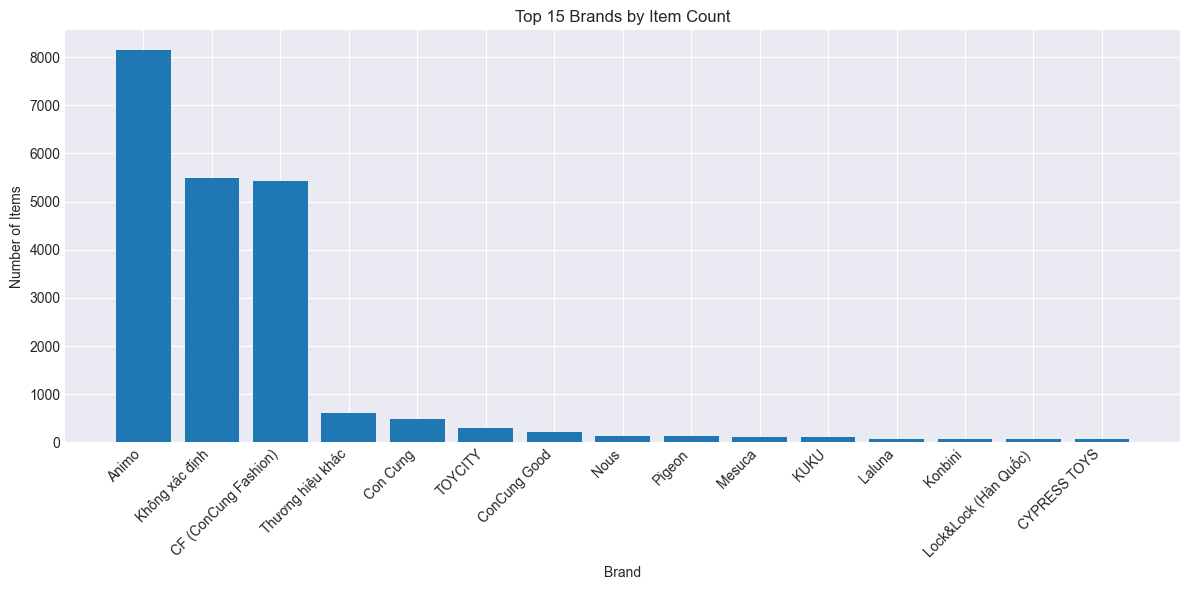

In [14]:
# Brand distribution
brand_dist = items.group_by('brand').agg(pl.count().alias('count')).sort('count', descending=True)

print("\nTop 10 Brands:")
print(brand_dist.head(10))

# Plot top 15 brands
top_brands = brand_dist.head(15)
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_brands)), top_brands['count'].to_list())
plt.xticks(range(len(top_brands)), top_brands['brand'].to_list(), rotation=45, ha='right')
plt.xlabel('Brand')
plt.ylabel('Number of Items')
plt.title('Top 15 Brands by Item Count')
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16420\1058443868.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  age_group_dist = items.group_by('age_group').agg(pl.count().alias('count')).sort('count', descending=True)



Age Group Distribution:
shape: (112, 2)
┌─────────────────────────────┬───────┐
│ age_group                   ┆ count │
│ ---                         ┆ ---   │
│ str                         ┆ u32   │
╞═════════════════════════════╪═══════╡
│ Không xác định              ┆ 15812 │
│ Từ 3Y                       ┆ 944   │
│ 9M-12M                      ┆ 844   │
│ 6M-9M                       ┆ 672   │
│ Từ 1Y                       ┆ 609   │
│ Từ 2Y                       ┆ 577   │
│ 3M-6M                       ┆ 545   │
│ Từ 6M                       ┆ 508   │
│ 0-12M                       ┆ 431   │
│ Từ 0M                       ┆ 430   │
│ …                           ┆ …     │
│ ["Từ 0M", "Từ 3M"]          ┆ 1     │
│ 2M-15M                      ┆ 1     │
│ Từ 19Y                      ┆ 1     │
│ 12M-4Y                      ┆ 1     │
│ 13M-24M                     ┆ 1     │
│ Từ 13Y                      ┆ 1     │
│ ["Từ 3M", "Từ 6M", "Từ 1Y"] ┆ 1     │
│ 4M-4Y                       ┆ 1     │

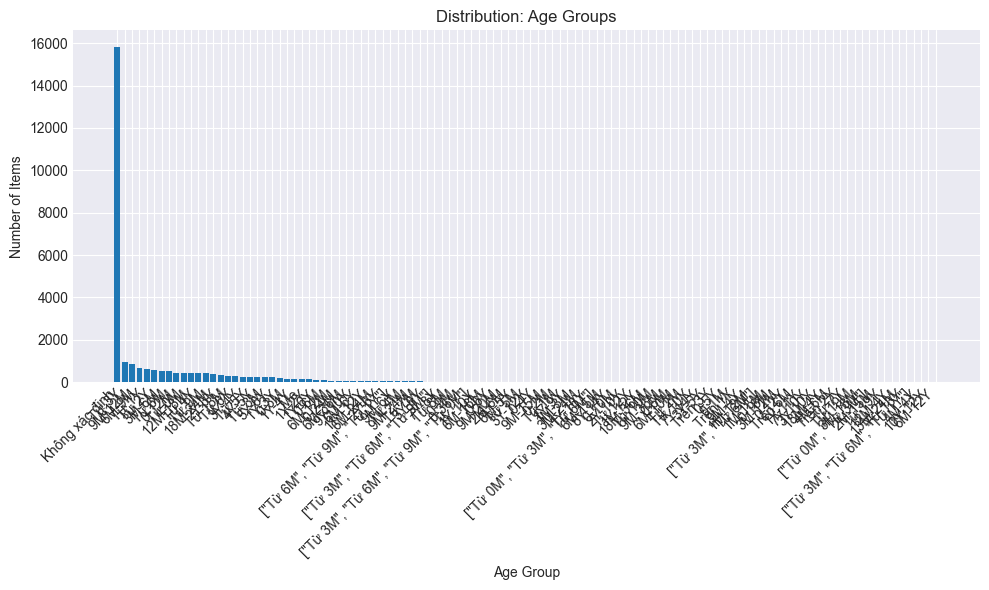

In [15]:
# Age group distribution
age_group_dist = items.group_by('age_group').agg(pl.count().alias('count')).sort('count', descending=True)

print("\nAge Group Distribution:")
print(age_group_dist)

plt.figure(figsize=(10, 6))
plt.bar(age_group_dist['age_group'].to_list(), age_group_dist['count'].to_list())
plt.xlabel('Age Group')
plt.ylabel('Number of Items')
plt.title('Distribution: Age Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Top 10 Categories:
shape: (10, 2)
┌───────────────────────┬───────┐
│ category              ┆ count │
│ ---                   ┆ ---   │
│ str                   ┆ u32   │
╞═══════════════════════╪═══════╡
│ Bộ bé trai Animo      ┆ 1018  │
│ Bộ quần áo bé gái     ┆ 741   │
│ Bộ Modal lẻ           ┆ 740   │
│ Áo bé gái             ┆ 731   │
│ Bodysuit              ┆ 718   │
│ Áo sơ sinh            ┆ 713   │
│ Bộ bé trai Animo Easy ┆ 625   │
│ Quần sơ sinh          ┆ 618   │
│ Áo bé trai            ┆ 611   │
│ Áo sơ sinh Animo      ┆ 559   │
└───────────────────────┴───────┘


C:\Users\ASUS\AppData\Local\Temp\ipykernel_16420\1537040326.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  category_dist = items.group_by('category').agg(pl.count().alias('count')).sort('count', descending=True)


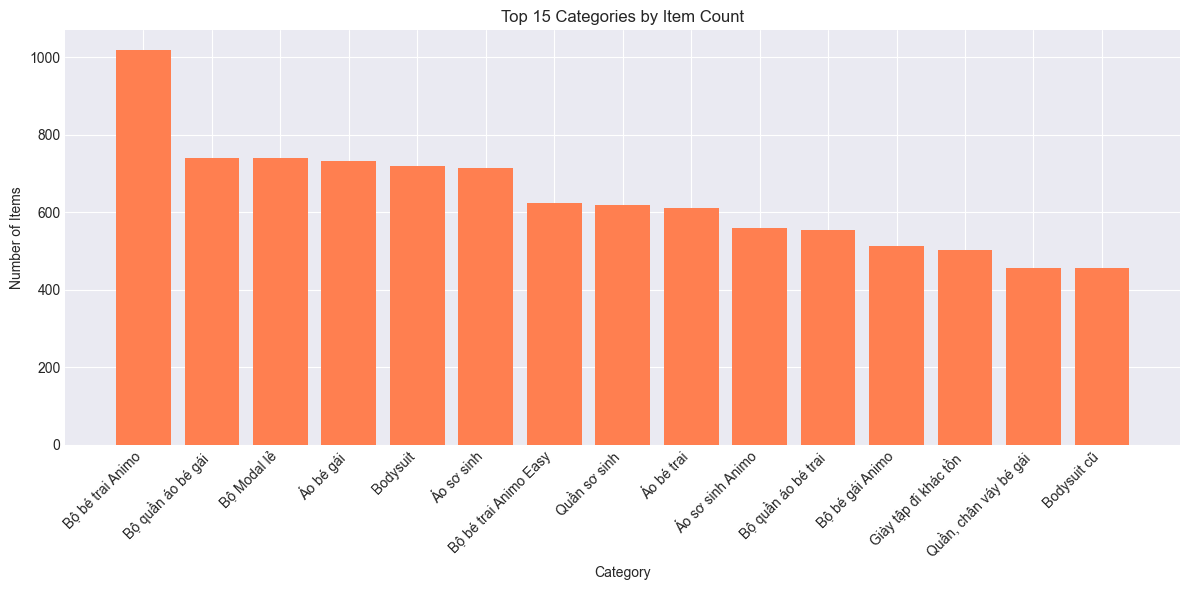

In [16]:
# Category distribution
category_dist = items.group_by('category').agg(pl.count().alias('count')).sort('count', descending=True)

print("\nTop 10 Categories:")
print(category_dist.head(10))

# Plot top 15 categories
top_categories = category_dist.head(15)
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_categories)), top_categories['count'].to_list(), color='coral')
plt.xticks(range(len(top_categories)), top_categories['category'].to_list(), rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Number of Items')
plt.title('Top 15 Categories by Item Count')
plt.tight_layout()
plt.show()

### 2.5 Temporal Patterns

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16420\1305815146.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('num_transactions')



Transaction Time Range:
shape: (1, 2)
┌─────────────────────────┬─────────────────────────┐
│ first_transaction       ┆ last_transaction        │
│ ---                     ┆ ---                     │
│ datetime[μs]            ┆ datetime[μs]            │
╞═════════════════════════╪═════════════════════════╡
│ 2024-01-01 06:58:27.420 ┆ 2024-12-31 22:34:04.687 │
└─────────────────────────┴─────────────────────────┘


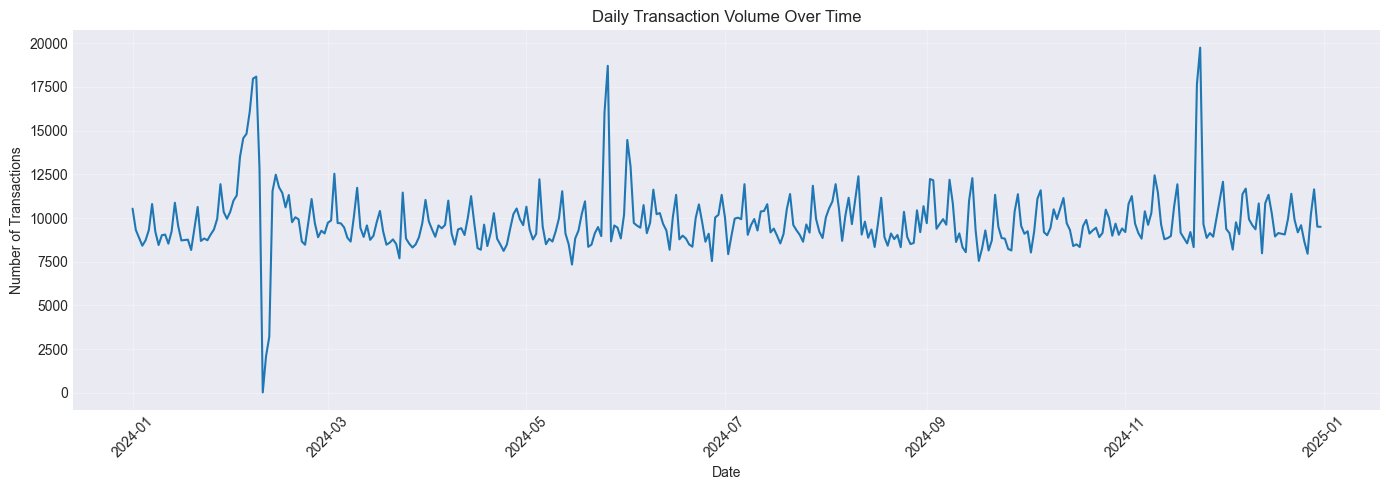

In [17]:
# Transaction time range
time_range = transactions.select([
    pl.col('created_date').min().alias('first_transaction'),
    pl.col('created_date').max().alias('last_transaction'),
])

print("\nTransaction Time Range:")
print(time_range)

# Daily transaction volume
daily_txns = transactions.group_by(
    pl.col('created_date').dt.date().alias('date')
).agg(
    pl.count().alias('num_transactions')
).sort('date')

plt.figure(figsize=(14, 5))
plt.plot(daily_txns['date'].to_list(), daily_txns['num_transactions'].to_list())
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Daily Transaction Volume Over Time')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Task 2: Multivariate Analysis

### 3.1 Sparsity Analysis

In [18]:
# Calculate interaction matrix sparsity
num_customers = transactions['customer_id'].n_unique()
num_items = transactions['item_id'].n_unique()
num_interactions = transactions.shape[0]
total_possible = num_customers * num_items
sparsity = 1 - (num_interactions / total_possible)

print(f"\n{'='*50}")
print("INTERACTION MATRIX SPARSITY")
print(f"{'='*50}")
print(f"Unique customers: {num_customers:,}")
print(f"Unique items: {num_items:,}")
print(f"Total interactions: {num_interactions:,}")
print(f"Possible interactions: {total_possible:,}")
print(f"Sparsity: {sparsity:.4%}")
print(f"Density: {(1-sparsity):.4%}")


INTERACTION MATRIX SPARSITY
Unique customers: 244,332
Unique items: 15,573
Total interactions: 3,583,618
Possible interactions: 3,804,982,236
Sparsity: 99.9058%
Density: 0.0942%


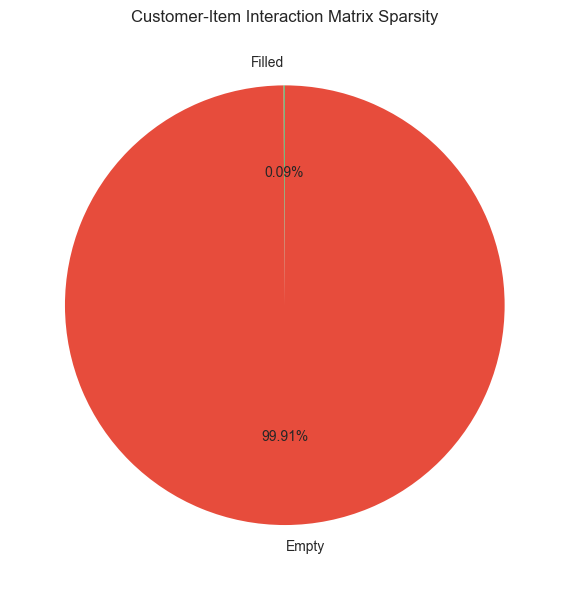

In [19]:
# Visualize sparsity
fig, ax = plt.subplots(figsize=(8, 6))
categories = ['Filled', 'Empty']
values = [1-sparsity, sparsity]
colors = ['#2ecc71', '#e74c3c']

ax.pie(values, labels=categories, autopct='%1.2f%%', colors=colors, startangle=90)
ax.set_title('Customer-Item Interaction Matrix Sparsity')
plt.tight_layout()
plt.show()

### 3.2 Purchase Patterns by Category

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16420\2919832316.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('num_purchases')



Top Categories by Purchase Volume:
shape: (10, 2)
┌────────────────┬───────────────┐
│ category       ┆ num_purchases │
│ ---            ┆ ---           │
│ str            ┆ u32           │
╞════════════════╪═══════════════╡
│ Hoff           ┆ 113835        │
│ Cây Thị        ┆ 65487         │
│ Ivenet         ┆ 63366         │
│ Sài Gòn Food   ┆ 59100         │
│ Vinamilk       ┆ 58748         │
│ Takato_Tã Quần ┆ 46684         │
│ Bebedang       ┆ 38054         │
│ Lineabon K2D3  ┆ 37365         │
│ Hạt nêm        ┆ 36872         │
│ Grow Plus đỏ   ┆ 36162         │
└────────────────┴───────────────┘


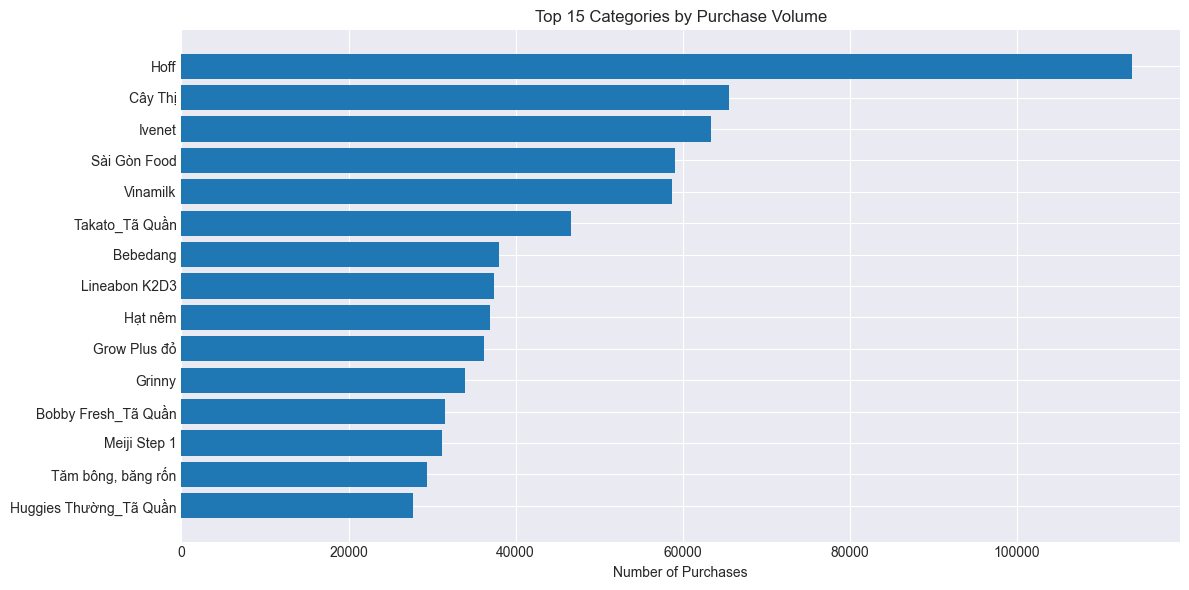

In [20]:
# Join transactions with items to analyze category purchases
txns_with_items = transactions.join(items, on='item_id', how='left')

# Category purchase volume
category_purchases = txns_with_items.group_by('category').agg(
    pl.count().alias('num_purchases')
).sort('num_purchases', descending=True)

print("\nTop Categories by Purchase Volume:")
print(category_purchases.head(10))

# Plot
top_cat = category_purchases.head(15)
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_cat)), top_cat['num_purchases'].to_list())
plt.yticks(range(len(top_cat)), top_cat['category'].to_list())
plt.xlabel('Number of Purchases')
plt.title('Top 15 Categories by Purchase Volume')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 3.3 Brand vs Age Group Analysis

In [21]:
# Cross-tabulation: Brand vs Age Group
brand_age = items.group_by(['brand', 'age_group']).agg(
    pl.count().alias('item_count')
)

# Get top 10 brands
top_10_brands = brand_dist.head(10)['brand'].to_list()

# Filter for top brands and pivot
brand_age_pivot = brand_age.filter(
    pl.col('brand').is_in(top_10_brands)
).pivot(
    index='brand',
    columns='age_group',
    values='item_count',
    aggregate_function='sum'
).fill_null(0)

print("\nBrand vs Age Group Matrix (Top 10 Brands):")
print(brand_age_pivot)


Brand vs Age Group Matrix (Top 10 Brands):
shape: (10, 75)
┌──────────────────────┬───────┬───────┬─────────┬───┬───────┬───────┬──────┬───────┐
│ brand                ┆ 2Y-3Y ┆ 3Y-4Y ┆ 18M-36M ┆ … ┆ 9M-4Y ┆ 6M-6Y ┆ 0-5M ┆ 0-24M │
│ ---                  ┆ ---   ┆ ---   ┆ ---     ┆   ┆ ---   ┆ ---   ┆ ---  ┆ ---   │
│ str                  ┆ u32   ┆ u32   ┆ u32     ┆   ┆ u32   ┆ u32   ┆ u32  ┆ u32   │
╞══════════════════════╪═══════╪═══════╪═════════╪═══╪═══════╪═══════╪══════╪═══════╡
│ Animo                ┆ 231   ┆ 149   ┆ 3       ┆ … ┆ 2     ┆ 65    ┆ 0    ┆ 72    │
│ CF (ConCung Fashion) ┆ 120   ┆ 115   ┆ 0       ┆ … ┆ 0     ┆ 0     ┆ 0    ┆ 0     │
│ TOYCITY              ┆ 0     ┆ 0     ┆ 0       ┆ … ┆ 0     ┆ 0     ┆ 0    ┆ 0     │
│ Không xác định       ┆ 0     ┆ 0     ┆ 0       ┆ … ┆ 0     ┆ 0     ┆ 0    ┆ 0     │
│ ConCung Good         ┆ 0     ┆ 0     ┆ 0       ┆ … ┆ 0     ┆ 0     ┆ 0    ┆ 0     │
│ Nous                 ┆ 0     ┆ 0     ┆ 0       ┆ … ┆ 0     ┆ 0     ┆ 0    ┆ 0 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16420\2990812099.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('item_count')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_16420\2990812099.py:12: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  ).pivot(


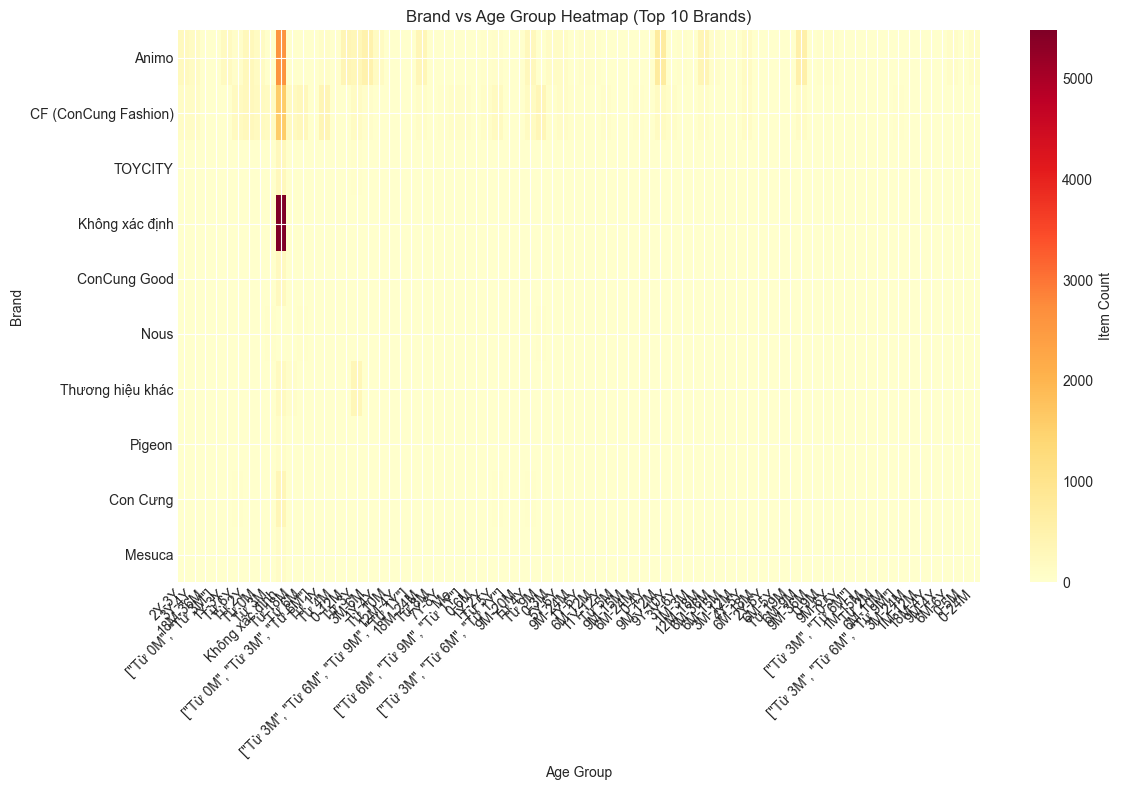

In [22]:
# Heatmap-style visualization
pivot_np = brand_age_pivot.select(pl.exclude('brand')).to_numpy()

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(pivot_np, aspect='auto', cmap='YlOrRd')

# Set ticks
ax.set_xticks(range(len(brand_age_pivot.columns[1:])))
ax.set_yticks(range(len(brand_age_pivot)))
ax.set_xticklabels(brand_age_pivot.columns[1:], rotation=45, ha='right')
ax.set_yticklabels(brand_age_pivot['brand'].to_list())

# Add colorbar
plt.colorbar(im, ax=ax, label='Item Count')

ax.set_title('Brand vs Age Group Heatmap (Top 10 Brands)')
ax.set_xlabel('Age Group')
ax.set_ylabel('Brand')

plt.tight_layout()
plt.show()

### 3.4 Cohort-Like Time Analysis

In [23]:
# Customer first purchase month
customer_first_purchase = transactions.group_by('customer_id').agg(
    pl.col('created_date').min().alias('first_purchase')
).with_columns(
    pl.col('first_purchase').dt.month_start().alias('cohort_month')
)

# Join back to transactions
cohort_txns = transactions.join(
    customer_first_purchase.select(['customer_id', 'cohort_month']),
    on='customer_id',
    how='left'
).with_columns(
    pl.col('created_date').dt.month_start().alias('purchase_month')
)

# Calculate months since first purchase
cohort_analysis = cohort_txns.with_columns(
    ((pl.col('purchase_month') - pl.col('cohort_month')).dt.total_days() / 30).floor().cast(pl.Int32).alias('months_since_first')
).group_by(['cohort_month', 'months_since_first']).agg(
    pl.n_unique('customer_id').alias('active_customers')
).sort(['cohort_month', 'months_since_first'])

print("\nCohort Analysis (Sample):")
print(cohort_analysis.head(20))


Cohort Analysis (Sample):
shape: (20, 3)
┌─────────────────────────┬────────────────────┬──────────────────┐
│ cohort_month            ┆ months_since_first ┆ active_customers │
│ ---                     ┆ ---                ┆ ---              │
│ datetime[μs]            ┆ i32                ┆ u32              │
╞═════════════════════════╪════════════════════╪══════════════════╡
│ 2024-01-01 06:47:11.070 ┆ 0                  ┆ 1                │
│ 2024-01-01 06:47:11.070 ┆ 1                  ┆ 1                │
│ 2024-01-01 06:47:11.070 ┆ 2                  ┆ 1                │
│ 2024-01-01 06:47:28.290 ┆ 0                  ┆ 1                │
│ 2024-01-01 06:49:46.400 ┆ 0                  ┆ 1                │
│ 2024-01-01 06:51:45.823 ┆ 0                  ┆ 1                │
│ 2024-01-01 06:51:45.823 ┆ 1                  ┆ 1                │
│ 2024-01-01 06:51:45.823 ┆ 2                  ┆ 1                │
│ 2024-01-01 06:51:45.823 ┆ 3                  ┆ 1                │
│ 2024

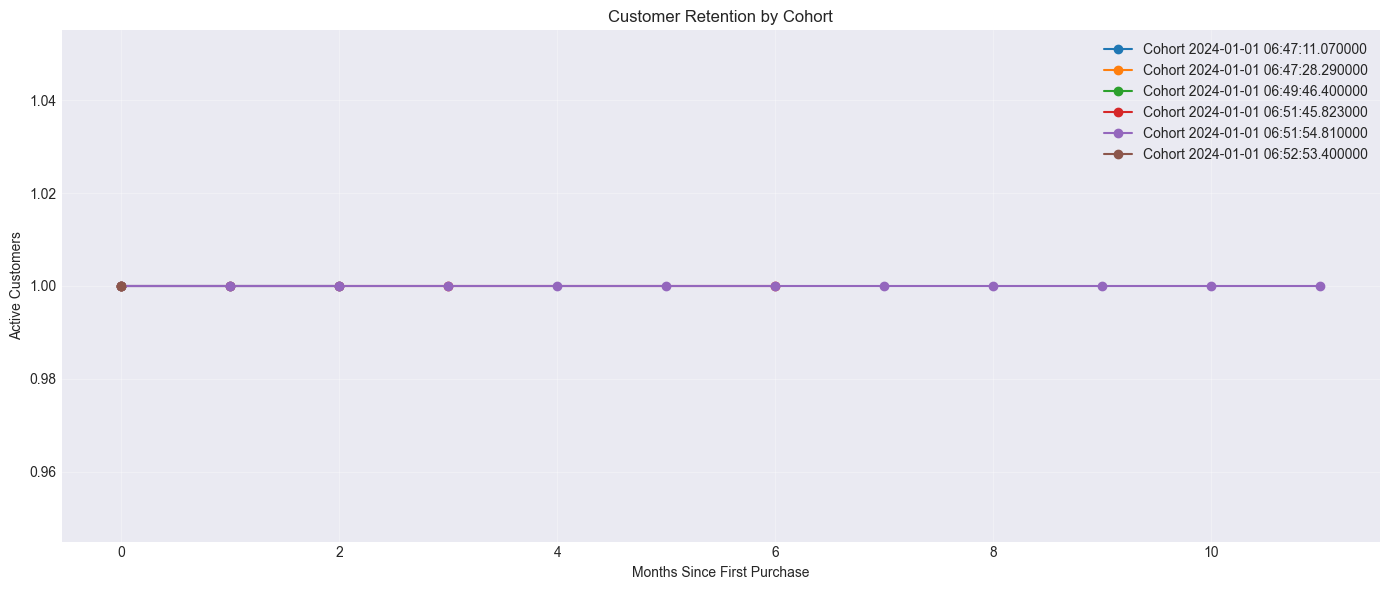

In [24]:
# Plot retention by cohort
# Select a few cohorts for visualization
sample_cohorts = cohort_analysis['cohort_month'].unique().sort().head(6).to_list()

plt.figure(figsize=(14, 6))

for cohort in sample_cohorts:
    cohort_data = cohort_analysis.filter(pl.col('cohort_month') == cohort)
    plt.plot(
        cohort_data['months_since_first'].to_list(),
        cohort_data['active_customers'].to_list(),
        marker='o',
        label=f'Cohort {cohort}'
    )

plt.xlabel('Months Since First Purchase')
plt.ylabel('Active Customers')
plt.title('Customer Retention by Cohort')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 3.5 Purchase Frequency Correlation

In [25]:
# Analyze relationship between customer activity metrics
customer_metrics = customer_stats.select([
    'num_purchases',
    'num_unique_items',
    'days_active'
])

# Compute correlation matrix
corr_matrix = customer_metrics.to_pandas().corr()

print("\nCustomer Metrics Correlation Matrix:")
print(corr_matrix)


Customer Metrics Correlation Matrix:
                  num_purchases  num_unique_items  days_active
num_purchases          1.000000          0.953935     0.606403
num_unique_items       0.953935          1.000000     0.627550
days_active            0.606403          0.627550     1.000000


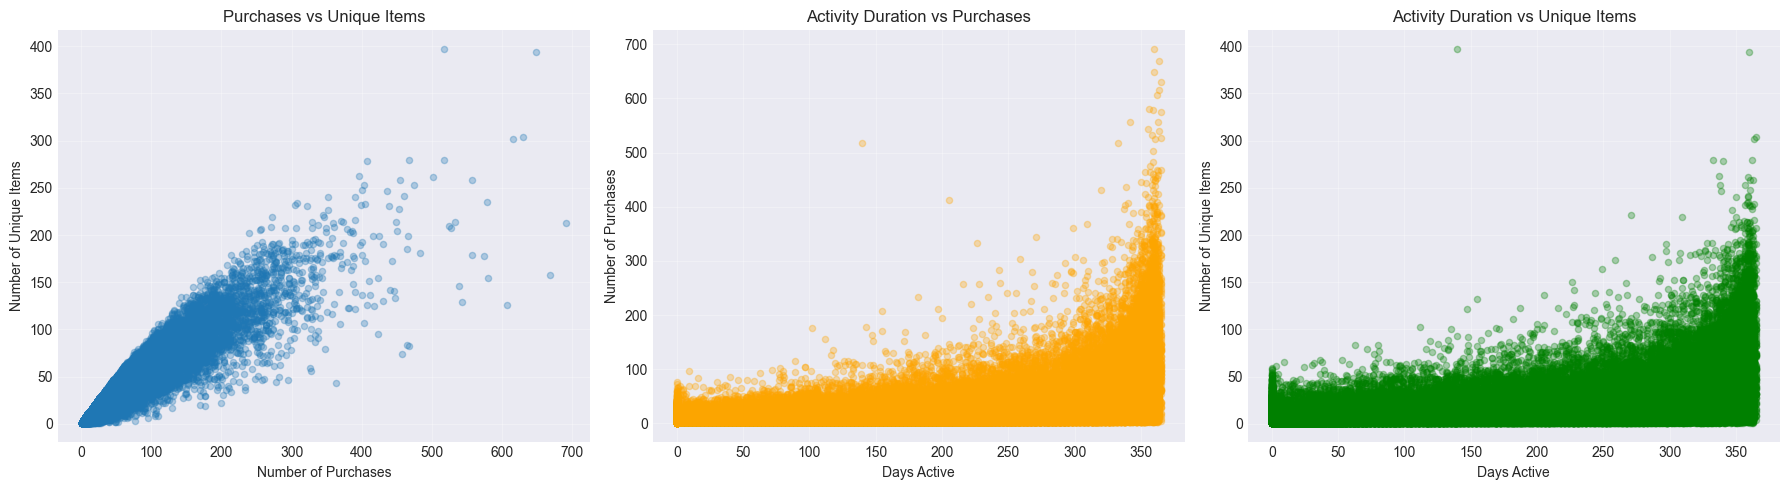

In [26]:
# Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Purchases vs Unique Items
axes[0].scatter(
    customer_stats['num_purchases'].to_numpy(),
    customer_stats['num_unique_items'].to_numpy(),
    alpha=0.3, s=20
)
axes[0].set_xlabel('Number of Purchases')
axes[0].set_ylabel('Number of Unique Items')
axes[0].set_title('Purchases vs Unique Items')
axes[0].grid(alpha=0.3)

# Days Active vs Purchases
axes[1].scatter(
    customer_stats['days_active'].to_numpy(),
    customer_stats['num_purchases'].to_numpy(),
    alpha=0.3, s=20, color='orange'
)
axes[1].set_xlabel('Days Active')
axes[1].set_ylabel('Number of Purchases')
axes[1].set_title('Activity Duration vs Purchases')
axes[1].grid(alpha=0.3)

# Days Active vs Unique Items
axes[2].scatter(
    customer_stats['days_active'].to_numpy(),
    customer_stats['num_unique_items'].to_numpy(),
    alpha=0.3, s=20, color='green'
)
axes[2].set_xlabel('Days Active')
axes[2].set_ylabel('Number of Unique Items')
axes[2].set_title('Activity Duration vs Unique Items')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Task 3: Preprocessing Recommendations

### 4.1 Outlier Detection

In [27]:
def detect_outliers_iqr(df: pl.DataFrame, column: str) -> dict:
    """Detect outliers using IQR method."""
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = df.filter(
        (pl.col(column) < lower_bound) | (pl.col(column) > upper_bound)
    ).shape[0]
    
    return {
        'column': column,
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'num_outliers': outliers,
        'outlier_rate': outliers / df.shape[0]
    }

# Detect outliers in customer metrics
print("\n" + "="*60)
print("OUTLIER DETECTION - Customer Metrics")
print("="*60)

for col in ['num_purchases', 'num_unique_items', 'days_active']:
    outlier_info = detect_outliers_iqr(customer_stats, col)
    print(f"\n{col}:")
    print(f"  Q1: {outlier_info['q1']:.2f}")
    print(f"  Q3: {outlier_info['q3']:.2f}")
    print(f"  IQR: {outlier_info['iqr']:.2f}")
    print(f"  Bounds: [{outlier_info['lower_bound']:.2f}, {outlier_info['upper_bound']:.2f}]")
    print(f"  Outliers: {outlier_info['num_outliers']} ({outlier_info['outlier_rate']:.2%})")


OUTLIER DETECTION - Customer Metrics

num_purchases:
  Q1: 1.00
  Q3: 13.00
  IQR: 12.00
  Bounds: [-17.00, 31.00]
  Outliers: 30284 (12.39%)

num_unique_items:
  Q1: 1.00
  Q3: 10.00
  IQR: 9.00
  Bounds: [-12.50, 23.50]
  Outliers: 29101 (11.91%)

days_active:
  Q1: 0.00
  Q3: 201.00
  IQR: 201.00
  Bounds: [-301.50, 502.50]
  Outliers: 0 (0.00%)


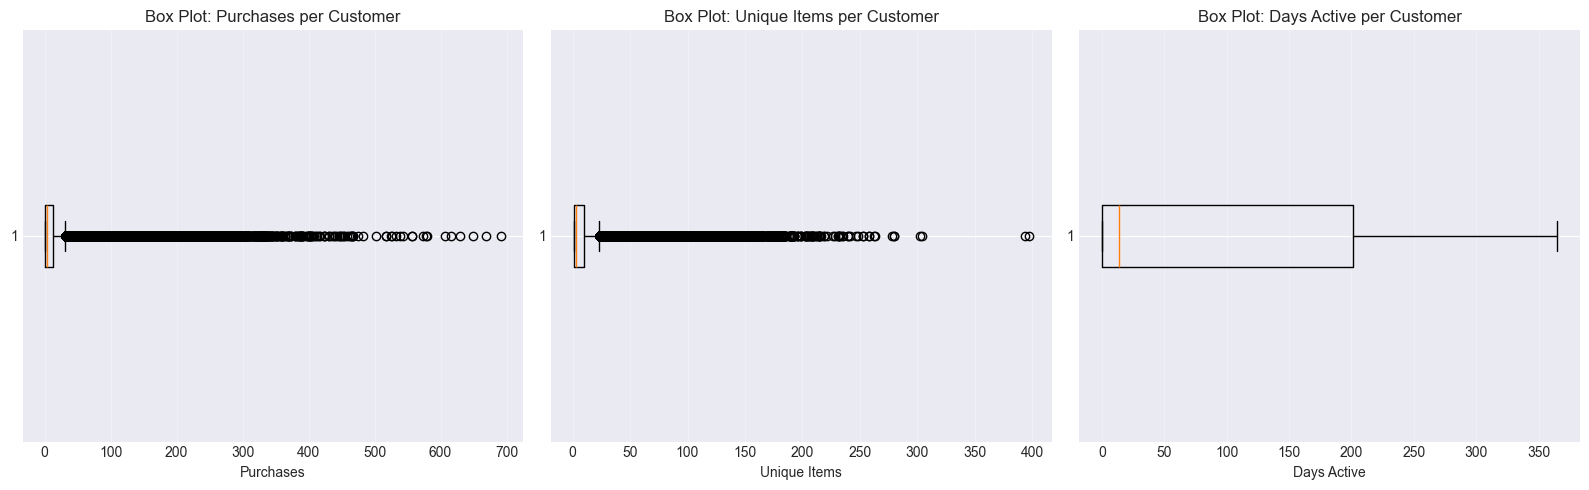

In [28]:
# Visualize outliers with box plots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics = ['num_purchases', 'num_unique_items', 'days_active']
titles = ['Purchases', 'Unique Items', 'Days Active']

for ax, metric, title in zip(axes, metrics, titles):
    data = customer_stats[metric].to_numpy()
    ax.boxplot([data], vert=False)
    ax.set_xlabel(title)
    ax.set_title(f'Box Plot: {title} per Customer')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Data Quality Summary

In [29]:
print("\n" + "="*70)
print("DATA QUALITY SUMMARY")
print("="*70)

print("\n1. DUPLICATES:")
print(f"   Transactions: {transactions.shape[0] - transactions.unique().shape[0]} duplicate rows")
print(f"   Items: {items.shape[0] - items.unique().shape[0]} duplicate rows")
print(f"   Users: {users.shape[0] - users.unique().shape[0]} duplicate rows")

print("\n2. ID CONSISTENCY:")
txn_customers = set(transactions['customer_id'].unique().to_list())
user_ids = set(users['customer_id'].unique().to_list())
txn_items = set(transactions['item_id'].unique().to_list())
item_ids = set(items['item_id'].unique().to_list())

print(f"   Customers in txns not in users: {len(txn_customers - user_ids)}")
print(f"   Items in txns not in items table: {len(txn_items - item_ids)}")

print("\n3. TEMPORAL CONSISTENCY:")
if 'date_of_birth' in users.columns:
    future_dob = users.filter(pl.col('date_of_birth') > pl.lit(datetime.now().date())).shape[0]
    print(f"   Users with future date_of_birth: {future_dob}")


DATA QUALITY SUMMARY

1. DUPLICATES:
   Transactions: 11 duplicate rows
   Items: 0 duplicate rows
   Users: 0 duplicate rows

2. ID CONSISTENCY:
   Customers in txns not in users: 0
   Items in txns not in items table: 0

3. TEMPORAL CONSISTENCY:


### 4.3 Preprocessing Recommendations

In [30]:
recommendations = """
═══════════════════════════════════════════════════════════════════
                   PREPROCESSING RECOMMENDATIONS
═══════════════════════════════════════════════════════════════════

1. COLUMNS TO DROP/HANDLE:
   ✓ Check null rates above 50% - consider dropping or imputing
   ✓ If 'order_id' has high nulls but not needed, can drop
   ✓ Redundant ID columns should be removed after joining

2. NULL HANDLING PLAN:
   Transactions:
   - customer_id, item_id, created_at: DROP rows (critical fields)
   - order_id: Fill with auto-generated ID or keep null if not used
   
   Items:
   - item_id: DROP rows (primary key)
   - brand/category/age_group: Fill with 'Unknown' or mode
   
   Users:
   - customer_id: DROP rows (primary key)
   - date_of_birth: Keep null or impute with median/mode

3. OUTLIER HANDLING:
   Customer Metrics:
   - Cap extreme purchase counts at 99th percentile
   - Consider log transformation for skewed distributions
   - Flag power users (top 1%) for separate analysis
   
   Item Metrics:
   - Handle cold-start items (< 5 purchases) separately
   - Consider minimum support thresholds

4. FEATURE ENGINEERING SUGGESTIONS:
   Time-based:
   - Recency: days since last purchase
   - Frequency: purchases per active day
   - Seasonality: month, day of week, holidays
   
   Interaction:
   - Purchase velocity: purchases / days_active
   - Category diversity: unique categories purchased
   - Repeat purchase rate: items bought multiple times
   
   Categorical:
   - One-hot encode brand, category, age_group
   - Or use target encoding for high cardinality

5. DATA SPLITS:
   Recommendation: Time-based split (not random!)
   - Training: transactions before date T
   - Validation: T to T+14 days
   - Test: T+14 to T+30 days
   
   Prevents data leakage and mimics production scenario

6. COLD START HANDLING:
   - New users: Use popularity-based recommendations
   - New items: Require minimum interaction threshold
   - Consider hybrid approach with content-based features

7. SPARSITY MITIGATION:
   Given high sparsity (>99%):
   - Use negative sampling for training
   - Consider matrix factorization or embedding methods
   - Implement candidate generation stage (top-K retrieval)

═══════════════════════════════════════════════════════════════════
"""

print(recommendations)


═══════════════════════════════════════════════════════════════════
                   PREPROCESSING RECOMMENDATIONS
═══════════════════════════════════════════════════════════════════

1. COLUMNS TO DROP/HANDLE:
   ✓ Check null rates above 50% - consider dropping or imputing
   ✓ If 'order_id' has high nulls but not needed, can drop
   ✓ Redundant ID columns should be removed after joining

2. NULL HANDLING PLAN:
   Transactions:
   - customer_id, item_id, created_at: DROP rows (critical fields)
   - order_id: Fill with auto-generated ID or keep null if not used

   Items:
   - item_id: DROP rows (primary key)
   - brand/category/age_group: Fill with 'Unknown' or mode

   Users:
   - customer_id: DROP rows (primary key)
   - date_of_birth: Keep null or impute with median/mode

3. OUTLIER HANDLING:
   Customer Metrics:
   - Cap extreme purchase counts at 99th percentile
   - Consider log transformation for skewed distributions
   - Flag power users (top 1%) for separate analysis

   I

### 4.4 Quick Preprocessing Pipeline Example

In [31]:
def preprocess_transactions(df: pl.DataFrame) -> pl.DataFrame:
    """Example preprocessing pipeline for transactions."""
    return (
        df
        # Remove nulls in critical columns
        .filter(
            pl.col('customer_id').is_not_null() &
            pl.col('item_id').is_not_null() &
            pl.col('created_date').is_not_null()
        )
        # Remove duplicates
        .unique()
        # Sort by time
        .sort('created_date')
    )

def preprocess_items(df: pl.DataFrame) -> pl.DataFrame:
    """Example preprocessing pipeline for items."""
    return (
        df
        .filter(pl.col('item_id').is_not_null())
        # Fill categorical nulls
        .with_columns([
            pl.col('brand').fill_null('Unknown'),
            pl.col('category').fill_null('Unknown'),
            pl.col('age_group').fill_null('Unknown'),
        ])
        .unique(subset=['item_id'])
    )

def preprocess_users(df: pl.DataFrame) -> pl.DataFrame:
    """Example preprocessing pipeline for users."""
    return (
        df
        .filter(pl.col('customer_id').is_not_null())
        .unique(subset=['customer_id'])
    )

print("Preprocessing pipeline functions defined.")
print("\nUsage:")
print("  clean_txns = preprocess_transactions(transactions)")
print("  clean_items = preprocess_items(items)")
print("  clean_users = preprocess_users(users)")

Preprocessing pipeline functions defined.

Usage:
  clean_txns = preprocess_transactions(transactions)
  clean_items = preprocess_items(items)
  clean_users = preprocess_users(users)


## Summary

This EDA notebook covered:
- **Task 1**: Univariate analysis (null rates, distributions, top items/customers)
- **Task 2**: Multivariate analysis (sparsity, correlations, cohort retention)
- **Task 3**: Preprocessing recommendations (outliers, null handling, feature engineering)

Next steps:
1. Apply preprocessing pipeline
2. Implement time-based train/test split
3. Generate candidates using methods from `candidates.py`
4. Build features using `build_feature_label_table()`
5. Train and evaluate recommender model